In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras as keras
from tensorflow.keras import layers, models, optimizers, metrics
tf.config.optimizer.set_jit(True)

In [2]:
from scipy.ndimage import convolve

class Connect4Game(object):
  def __init__(self):
    self.board = np.zeros((6, 7)).astype(np.int8)
    self.tops = np.zeros(7).astype(np.int8)
    self.moves_played = 0
    self.pieces = {1: "|0|",
                   0: "|·|",
                   -1:"|O|"}
  def render(self):
    for row in reversed(range(6)):
      print(''.join([self.pieces[i] for i in self.board[row].astype(np.int)]))
  def reset(self):
    self.board *= 0
    self.tops *= 0
    self.moves_played = 0
  def play(self, col, color):
    self.board[int(self.tops[col])][col] = color
    self.tops[col] += 1
    self.moves_played += 1
  def result(self):
    """ Returns 0 if it's a tie; returns None if the game is not over; returns -1 if player -1 wins, and 1 if player 1 wins."""
    if self.moves_played == 42: return 0
    kernel_row = [[1, 1, 1, 1]]
    kernel_col = [[1],
                  [1],
                  [1],
                  [1]]
    kernel_dia = [[1, 0, 0, 0],
                  [0, 1, 0, 0],
                  [0, 0, 1, 0],
                  [0, 0, 0, 1]]
    kernel_dia2 = [[0, 0, 0, 1],
                  [0, 0, 1, 0],
                  [0, 1, 0, 0],
                  [1, 0, 0, 0]]
    for kernel in [np.array(kernel_row).astype(np.int8), np.array(kernel_col).astype(np.int8), np.array(kernel_dia).astype(np.int8), np.array(kernel_dia2).astype(np.int8)]:
      check = convolve(self.board, kernel, mode='constant')
      #print(check)
      if (check == 4).any(): return 1
      if (check == -4).any(): return -1
    return None 

In [3]:
def human_play():
  game = Connect4Game()
  turn = 1
  while game.result() == None:
    game.render()
    game.play(int(input()), turn); turn *= -1
  print("Result: ", game.result())

In [4]:
from PIL import Image
from collections import defaultdict
import random
import time, tqdm

class A0(object):
    def __init__(self, model_complexity = 2, n_simulations = 64, model = None):
        # Hyperparameters
        self.n_simulations = n_simulations # Keep it simple
        self.c = 1 # weight for exploration
        
        # Basic
        
        self.simulator = Connect4Game() # Would be different if this were muzero
        self.model_complexity = model_complexity # 1+
        if model == None:
            self.model = self.create_model(conv_layers = self.model_complexity, describe = True)
        else:
            print("Loading model from memory.")
            self.model = model
        
        # Data
        self.states = []
        self.Q_target = []
        self.P_target = []
        
        # Monte Carlo Tree Search stuff
        self.visited = set()
        self.Q, self.P, self.N = defaultdict(lambda: np.zeros(7).astype(np.float32)), {}, defaultdict(lambda: np.zeros(7).astype(np.uint8))

        
    def create_model(self, conv_layers = 2,describe = False):
        in_ = layers.Input((6, 7, 1))
        X = layers.Conv2D(32, (4,4), activation = 'relu', padding = "same")(in_)
        for i in range(conv_layers-1):
            X_skip = layers.Conv2D(32, (3,3), activation = 'relu', padding = "same")(X)
            X_skip = layers.BatchNormalization()(X_skip)
            X_skip = layers.Conv2D(32, (2,2), activation = 'relu', padding = "same")(X_skip)
            X_skip = layers.BatchNormalization()(X_skip)
            X = layers.BatchNormalization()(X)
            X = layers.Add()([X_skip, X])
        X = layers.Conv2D(32, (2,2), activation = 'relu')(X)
        X = layers.BatchNormalization()(X)
        #X = layers.GlobalAveragePooling2D()(X)
        X = layers.Flatten()(X)
        #P = layers.Dense(32, activation = 'relu')(X)
        P = layers.Dense(7, activation = 'softmax', name = "P_head")(X) # Check the activations here
        Q = layers.Dense(8, activation = 'relu')(X)
        Q = layers.Dense(1, activation = 'tanh', name = "Q_head")(Q)
        model = models.Model(in_, [P, Q])
        model.compile(optimizer=optimizers.Adam(0.001), loss={'P_head': "binary_crossentropy", 'Q_head': "mse"})
        
        if describe: 
            tf.keras.utils.plot_model(
                model,
                to_file="model.png",
                show_shapes=True,
                show_dtype=True,
                show_layer_names=True,
                rankdir="TB",
                expand_nested=False,
                dpi=120,
                layer_range=None,
                show_layer_activations=True,
            )
            img = Image.open("model.png")
            wpercent = (750/float(img.size[0]))
            hsize = int((float(img.size[1])*float(wpercent)))
            img = img.resize((750,hsize), Image.Resampling.LANCZOS)
            display(img)
            
            trainableParams = np.sum([np.prod(v.get_shape()) for v in model.trainable_weights])
            nonTrainableParams = np.sum([np.prod(v.get_shape()) for v in model.non_trainable_weights])
            totalParams = trainableParams + nonTrainableParams

            print("Trainable parameters:", trainableParams)
            print("Untrainable parameters:",nonTrainableParams)
            print("Total parameters:",totalParams)
        return model        
    
    def MCTS(self, game, turn):
        self.simulator.board = game.board
        self.simulator.tops = game.tops
        self.simulator.moves_played = game.moves_played
        
        if self.simulator.result() != None: return -self.simulator.result() * turn # It's over, Anakin!
        # TODO: CHECK HOW THE ABOVE INTERACTS WITH THE SIGN SWITCHING
        s = self.simulator.board * turn
            
        if s.tobytes() not in self.visited:
            """
            Let's be very clear about this. The model is NOT TURN AGNOSTIC: the board is flipped to encode the active 
            player's pieces as 1 at all times.
            
            The Q head of the model predicts the quality of the board between 1 and -1 (thus the tanh activation).
            Positions more favored for the current player have qualities approaching 1; positions favored for the
            adversary have qualities approaching -1. 
            
            The P head of the model predicts how promising each action is for the current player. Note that
            keeping the model turn agnostic would necessitate passing in the current turn to the P head (as to denote
            the player whose moves' potentials would have to be calculated) and lay an unnecessary burden upon the P network.
            
            Also, the tanh activation and (1, -1) encoding is so that multiplying v by -1 yields v for the opponent (convenient!)
            """
            self.visited.add(s.tobytes())
            # self.P[s.tobytes()], v = np.ones(7)/7, 0 #DEBUG ONLY
            
            p_, v_ = self.model(s[np.newaxis, :, :, np.newaxis]) # Why not save v as the starting value for Q[s][a], you may ask?
                        # Because that injects bias into the MCTS, and we want to keep the "pure" MCTS output to boost the model.
                        # Essentially, we want to minimize the potential for feedback loops as much as possible (model predicting
                        # high initial quality, MCTS outputting high initial quality and prodicing biased games, etc).
            self.P[s.tobytes()] = p_[0]
            v = v_[0]
                        
            return -v # Invert the quality. Let's imagine it's move 0 (the board state in the real game). On MCTS call 1, 
                        # the function returns -v (v = network at-a-glance), which is fine, since we don't care about the output 
                        # (only used to calculate N). On call 2, the function goes to the next move and evaluates the board for 
                        # the opponent (let's dub this o.) -o, or v, gets returned, and then v is used to update N and Q, before
                        # -v being returned to the main function. Notice that the value used to update N is always +v.
        
        legal_moves = [i for i in range(7) if game.tops[i] != 6]
        
        s = s.tobytes() # make it hashable
        best_a = random.choice(legal_moves) # inject randomness instead of using [0] to avoid making any one move extra prevalent in the case of a tie
        best_u = -float("inf")
        for a in legal_moves: # legal moves
            u = self.Q[s][a] + self.c * self.P[s][a] * np.sqrt(np.sum(self.N[s]))/(1+self.N[s][a]) # upper confidence bound (UCB) 
            if u > best_u: 
                best_a = a
                best_u = u
                
        a = best_a # FIGURE OUT WHY
        
        self.simulator.play(a, turn)
        v = self.MCTS(self.simulator, -turn)
        
        self.Q[s][a] = (self.N[s][a] * self.Q[s][a] + v) / (self.N[s][a] + 1) # Recalculate Q as the average quality
        self.N[s][a] += 1
        
        return -v
    
    def play_episode(self, debug = False):
        game = Connect4Game()
        turn = 1
        p1_states, pneg1_states = [], []
        if debug: times = []
        while (game.result() == None):
            for i in range(self.n_simulations):
                starttime = time.time()
                
                copy_game = Connect4Game()
                # Pass by copy (we don't want the internal MCTS to modify the outer game)
                copy_game.board = game.board.copy()
                copy_game.tops = game.tops.copy()
                copy_game.moves_played = game.moves_played # integer
                self.MCTS(copy_game, turn)
                
                if debug: times.append(time.time() - starttime)
                        
            s = (game.board * turn).tobytes()
            move_qualities = np.array([self.N[s][a] if game.tops[a] != 6 else 0 for a in range(7)])
                        
            self.visited.clear() # Reset tree
            if debug: 
              print("Turn: ", turn)
              game.render()
              print(self.N[s])
            self.N.clear()
            self.Q.clear()
            self.P.clear()
            
            probs = move_qualities / (np.sum(move_qualities) + 0.00001)
            probs *= (1/np.sum(probs))
            if debug: print(probs)
            
            # Double check if the agents are supposed to move based on their MCTS qualities or their predicted policy.
                        
            # Also double check if the policy network is supposed to be trained on the valid policy weights (softmaxed) 
            # as I do here (is it too burdensome to train the policy network using only the valid part of the MCTS policy distribution?)
            self.P_target.append(probs)
            assert turn == 1 or turn == -1
            if turn == 1:
                p1_states.append(game.board * turn)
            if turn == -1:
                pneg1_states.append(game.board * turn)
            action = np.random.choice(range(0, 7), p = probs)
            game.play(action, turn)

            turn *= -1
        
        self.states.extend(p1_states)
        self.Q_target.extend([game.result()]*len(p1_states)) # Label all qualities of the states from the pov of player 1 as 1 if p1 wins, -1 otherwise
        self.states.extend(pneg1_states)
        self.Q_target.extend([-game.result()]*len(pneg1_states)) # Label all qualities of the states from the pov of player -1 as -1 if p1 wins, 1 otherwise

        if debug: print("Average MCTS time:", sum(times) / len(times))
    def fit(self, batch_size, epochs):
        self.new = self.create_model(conv_layers = self.model_complexity, describe = False)
        self.new.set_weights(self.model.get_weights())
        self.new.fit(x = np.array(self.states), y = {"Q_head": np.array(self.Q_target), "P_head": np.array(self.P_target)}, batch_size = batch_size, epochs = epochs)
        return self.new

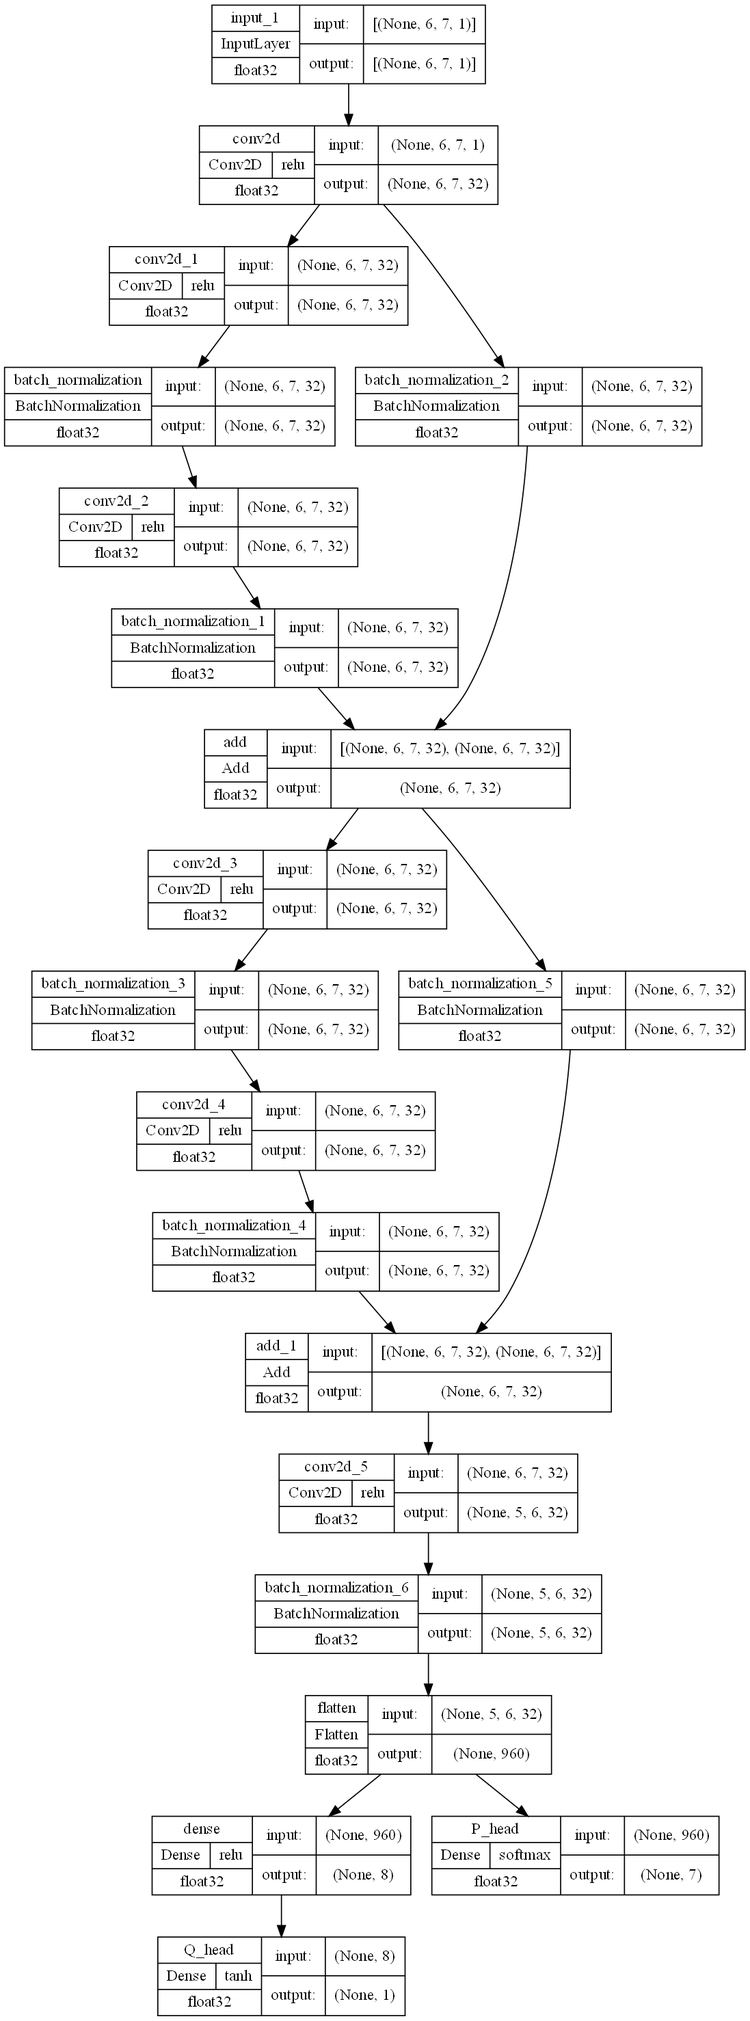

Trainable parameters: 46296
Untrainable parameters: 448
Total parameters: 46744


In [5]:
agent = A0(3, 64)

In [10]:
training_episodes = 1
for i in tqdm.trange(training_episodes):
    agent.play_episode(debug = True)


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

Turn:  1
|·||·||·||·||·||·||·|
|·||·||·||·||·||·||·|
|·||·||·||·||·||·||·|
|·||·||·||·||·||·||·|
|·||·||·||·||·||·||·|
|·||·||·||·||·||·||·|
[11  8 10  9  8  9  8]
[0.17460317 0.12698413 0.15873016 0.14285714 0.12698413 0.14285714
 0.12698413]


C:\Users\william\AppData\Local\Temp\ipykernel_42032\2263151622.py:13: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  print(''.join([self.pieces[i] for i in self.board[row].astype(np.int)]))


Turn:  -1
|·||·||·||·||·||·||·|
|·||·||·||·||·||·||·|
|·||·||·||·||·||·||·|
|·||·||·||·||·||·||·|
|·||·||·||·||·||·||·|
|·||·||·||·||·||0||·|
[12  8  9  8  9  8  9]
[0.19047619 0.12698413 0.14285714 0.12698413 0.14285714 0.12698413
 0.14285714]
Turn:  1
|·||·||·||·||·||·||·|
|·||·||·||·||·||·||·|
|·||·||·||·||·||·||·|
|·||·||·||·||·||·||·|
|·||·||·||·||·||O||·|
|·||·||·||·||·||0||·|
[10  8  9  9  8 11  8]
[0.15873016 0.12698413 0.14285714 0.14285714 0.12698413 0.17460317
 0.12698413]
Turn:  -1
|·||·||·||·||·||·||·|
|·||·||·||·||·||·||·|
|·||·||·||·||·||·||·|
|·||·||·||·||·||·||·|
|·||·||·||·||·||O||·|
|0||·||·||·||·||0||·|
[ 9  8  9  9  8 11  9]
[0.14285714 0.12698413 0.14285714 0.14285714 0.12698413 0.17460317
 0.14285714]
Turn:  1
|·||·||·||·||·||·||·|
|·||·||·||·||·||·||·|
|·||·||·||·||·||·||·|
|·||·||·||·||·||·||·|
|·||·||·||·||·||O||·|
|0||·||·||·||O||0||·|
[ 8  8 11 10  8 10  8]
[0.12698413 0.12698413 0.17460317 0.15873016 0.12698413 0.15873016
 0.12698413]
Turn:  -1
|·||·||·||·|

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:24<00:00, 24.21s/it]

Turn:  -1
|·||·||·||·||·||·||·|
|·||·||·||·||·||·||·|
|O||·||·||·||·||·||·|
|0||·||0||·||·||·||O|
|0||·||0||·||0||O||0|
|0||·||O||O||O||0||O|
[ 1 58  1  1  1  0  1]
[0.01587302 0.92063492 0.01587302 0.01587302 0.01587302 0.
 0.01587302]
Average MCTS time: 0.023615758633241057


In [12]:
training_episodes = 2000
for i in tqdm.trange(training_episodes):
    agent.play_episode(debug = False)

 13%|█████████▍                                                                | 255/2000 [2:13:31<15:13:41, 31.42s/it]


KeyboardInterrupt: 

In [16]:
new_model = agent.fit(64, 2)

Epoch 1/2
1/1 [==============================] - 3s 3s/step - loss: 1.8019 - P_head_loss: 0.9879 - Q_head_loss: 0.8140
Epoch 2/2
1/1 [==============================] - 0s 19ms/step - loss: 0.7965 - P_head_loss: 0.7448 - Q_head_loss: 0.0518


In [ ]:
challenger = A0(3, 64, new_model)

In [ ]:
matches = 128
agent_turn = (random.randint(0, 1) * 2) - 1
agent_score, challenger_score = 0, 0

for match in tqdm.trange(matches):
    game = Connect4Game()
    turn = 1
    while (game.result() == None):
        for i in range(self.n_simulations):
            starttime = time.time()

            copy_game = Connect4Game()
            # Pass by copy (we don't want the internal MCTS to modify the outer game)
            copy_game.board = game.board.copy()
            copy_game.tops = game.tops.copy()
            copy_game.moves_played = game.moves_played # integer
            if turn == agent_turn: agent.MCTS(copy_game, turn)
            else: challenger.MCTS(copy_game, turn)

        s = (game.board * turn).tobytes()
        
        if turn == agent_turn:
            move_qualities = np.array([agent.N[s][a] if game.tops[a] != 6 else 0 for a in range(7)])

            agent.visited.clear() # Reset tree
            # game.render() DEBUG
            agent.N.clear()
            agent.Q.clear()
            agent.P.clear()

        else:
            move_qualities = np.array([challenger.N[s][a] if game.tops[a] != 6 else 0 for a in range(7)])

            challenger.visited.clear() # Reset tree
            # game.render() DEBUG
            challenger.N.clear()
            challenger.Q.clear()
            challenger.P.clear()

        probs = move_qualities / (np.sum(move_qualities) + 0.00001)
        probs *= (1/np.sum(probs))

        action = np.random.choice(range(0, 7), p = probs)
        game.play(action, turn)

        turn *= -1
    if game.result() == agent_turn:
        agent_score += 1
    elif game.result() == challenger_turn:
        challenger_score += 1
    else:
        agent_score += 0.5
        challenger_score += 0.5

print("Challenger score:", challenger_score)
print("Benchmark score:", agent_score)
if challenger_score > sith_lord_threshold * agent_score:
    agent.model.set_weights(challenger.model.get_weights())
    del challenger

In [23]:
import cProfile
cProfile.run("agent.play_episode()")

Turn:  1
|·||·||·||·||·||·||·|
|·||·||·||·||·||·||·|
|·||·||·||·||·||·||·|
|·||·||·||·||·||·||·|
|·||·||·||·||·||·||·|
|·||·||·||·||·||·||·|
[ 9  9  8  9 10  9  9]
[0.14285714 0.14285714 0.12698413 0.14285714 0.15873016 0.14285714
 0.14285714]


C:\Users\william\AppData\Local\Temp\ipykernel_34184\2263151622.py:13: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  print(''.join([self.pieces[i] for i in self.board[row].astype(np.int)]))


Turn:  -1
|·||·||·||·||·||·||·|
|·||·||·||·||·||·||·|
|·||·||·||·||·||·||·|
|·||·||·||·||·||·||·|
|·||·||·||·||·||·||·|
|·||·||·||0||·||·||·|
[ 9 10  8  8 10  9  9]
[0.14285714 0.15873016 0.12698413 0.12698413 0.15873016 0.14285714
 0.14285714]
Turn:  1
|·||·||·||·||·||·||·|
|·||·||·||·||·||·||·|
|·||·||·||·||·||·||·|
|·||·||·||·||·||·||·|
|·||·||·||·||·||·||·|
|·||O||·||0||·||·||·|
[ 9 10  9  8  9  9  9]
[0.14285714 0.15873016 0.14285714 0.12698413 0.14285714 0.14285714
 0.14285714]
Turn:  -1
|·||·||·||·||·||·||·|
|·||·||·||·||·||·||·|
|·||·||·||·||·||·||·|
|·||·||·||·||·||·||·|
|·||0||·||·||·||·||·|
|·||O||·||0||·||·||·|
[10 10  7  9  9  9  9]
[0.15873016 0.15873016 0.11111111 0.14285714 0.14285714 0.14285714
 0.14285714]
Turn:  1
|·||·||·||·||·||·||·|
|·||·||·||·||·||·||·|
|·||·||·||·||·||·||·|
|·||·||·||·||·||·||·|
|·||0||·||·||·||·||·|
|O||O||·||0||·||·||·|
[ 9 10  8  9  9  9  9]
[0.14285714 0.15873016 0.12698413 0.14285714 0.14285714 0.14285714
 0.14285714]
Turn:  -1
|·||·||·||·|

In [ ]:
#Todo:
# 1. Figure out why player -1 lacks a sense of agency or self-preservation
# 2. Figure out why running the program takes so damn long

In [9]:
import tqdm
from tensorflow.keras.utils import plot_model
import tensorflow.keras.backend as kb

def create_P_network(NUM_CONV_LAYERS = 5, describe = True):
    in_ = layers.Input((6, 7))
    X = layers.Reshape((6, 7, 1))(in_)
    for i in range(NUM_CONV_LAYERS-1):
        X_skip = layers.Conv2D(32, (4,4), activation = 'relu', padding = "same")(X)
        X_skip = layers.BatchNormalization()(X_skip)
        X_skip = layers.Conv2D(32, (2,2), activation = 'relu', padding = "same")(X_skip)
        X_skip = layers.BatchNormalization()(X_skip)
        X = layers.BatchNormalization()(X)
        X = layers.Add()([X_skip, X])
    X = layers.Conv2D(32, (3,3), activation = 'relu')(X)
    X = layers.BatchNormalization()(X)
    #X = layers.GlobalAveragePooling2D()(X)
    X = layers.Flatten()(X)
    #X = layers.Dense(256, activation = 'relu')(X)
    X = layers.Dense(7, activation = 'softmax')(X)
    model = models.Model(in_, X)
    if describe: 
        model.summary()
    return model

class TrainBuffer(object):
    def __init__(self, max_queue = 50000, clean_extra = 10000):
        self.X1 = []; self.X2 = []
        self.y = []; self.max_queue = max_queue
        self.clean_extra = clean_extra
    def push(self, X1, X2, y):
        self.X1.extend(X1)
        self.X2.extend(X2)
        self.y.extend(y)
        #if len(self.y) > self.max_queue: self.y = self.y[len(self.y) - self.max_queue:]
        if len(self.X1) > self.max_queue + self.clean_extra:
            idxs = np.random.choice(len(self.X1), size = self.max_queue, replace = False)
            tmp_X1 = [self.X1[idxs[i]] for i in range(self.max_queue)]
            tmp_X2 = [self.X2[idxs[i]] for i in range(self.max_queue)]
            tmp_y = [self.y[idxs[i]] for i in range(self.max_queue)]
            self.X1 = tmp_X1
            self.X2 = tmp_X2
            self.y = tmp_y
            


class REINFORCELearner(object):
    def __init__(self):
        self.game = Connect4Game()
        self.model = create_P_network()
        self.teacher = create_P_network()
        self.buffer = TrainBuffer()
        self.train_every = 500
        self.gamma = 0.95
        self.model.compile(loss = "categorical_crossentropy", optimizer = optimizers.Adam(1e-4), metrics = ['acc', 'mse'])

    def norm_probs(self, probs):
        probs *= (self.game.tops != 6)
        probs *= (1 / np.sum(probs))
        return probs

    def push_to_buffer(self, result, p1_states, p1_actions, pneg1_states, pneg1_actions):
        if result == 1:
            labels = []; reward = 1
            for i in reversed(p1_actions):
                label = np.zeros(7); label[i] = reward; labels.append(label); reward *= self.gamma
            self.buffer.push(p1_states, p1_actions, reversed(labels))
        if result == -1:
            labels = []; reward = 1
            for i in reversed(pneg1_actions):
                label = np.zeros(7); label[i] = reward; labels.append(label); reward *= self.gamma
            self.buffer.push(pneg1_states, pneg1_actions, reversed(labels))
        
    def run_game(self):
        states_p1, actions_p1, states_pneg1, actions_pneg1 = [], [], [], []
        turn = 1
        while (self.game.result() == None):
            state = self.game.board * turn
            P = self.teacher(state[np.newaxis,:,:])
            preds = P.numpy()[0]
            probs = self.norm_probs(preds)

            action = np.random.choice(range(0, 7), p = probs)
            self.game.play(action, turn)
            if turn == 1: 
                states_p1.append(state)
                actions_p1.append(action)
            else: 
                states_pneg1.append(state)
                actions_pneg1.append(action)
            turn *= -1
            
        self.push_to_buffer(self.game.result(), states_p1, actions_p1, states_pneg1, actions_pneg1)
        self.game.reset()

    def train(self, epochs = 1):
        for j in tqdm.trange(epochs):
            for i in range(self.train_every):
                self.run_game()
            self.model.fit(x = np.array(self.buffer.X1), y = np.array(self.buffer.y), batch_size = 512)

C:\Users\william\AppData\Local\Temp\ipykernel_58468\3749769882.py:14: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  print(''.join([self.pieces[i] for i in self.board[row].astype(np.int)]))


|·||·||·||·||·||·||·|
|·||·||·||·||·||·||·|
|·||·||·||·||·||·||·|
|·||·||·||·||·||·||·|
|·||·||·||·||·||·||·|
|·||·||·||·||·||·||·|
3
|·||·||·||·||·||·||·|
|·||·||·||·||·||·||·|
|·||·||·||·||·||·||·|
|·||·||·||·||·||·||·|
|·||·||·||·||·||·||·|
|·||·||·||0||·||·||·|
3
|·||·||·||·||·||·||·|
|·||·||·||·||·||·||·|
|·||·||·||·||·||·||·|
|·||·||·||·||·||·||·|
|·||·||·||O||·||·||·|
|·||·||·||0||·||·||·|
3
|·||·||·||·||·||·||·|
|·||·||·||·||·||·||·|
|·||·||·||·||·||·||·|
|·||·||·||0||·||·||·|
|·||·||·||O||·||·||·|
|·||·||·||0||·||·||·|
3
|·||·||·||·||·||·||·|
|·||·||·||·||·||·||·|
|·||·||·||O||·||·||·|
|·||·||·||0||·||·||·|
|·||·||·||O||·||·||·|
|·||·||·||0||·||·||·|
3
|·||·||·||·||·||·||·|
|·||·||·||0||·||·||·|
|·||·||·||O||·||·||·|
|·||·||·||0||·||·||·|
|·||·||·||O||·||·||·|
|·||·||·||0||·||·||·|
3
|·||·||·||O||·||·||·|
|·||·||·||0||·||·||·|
|·||·||·||O||·||·||·|
|·||·||·||0||·||·||·|
|·||·||·||O||·||·||·|
|·||·||·||0||·||·||·|
4
|·||·||·||O||·||·||·|
|·||·||·||0||·||·||·|
|·||·||·||O||·||·|